# Pronóstico de erupciones volcánicas
- Alvarado Morán Óscar
- Bermúdez Marbán Dante

In [1]:
from threading import Thread      # Para el chistecito del paralelismo
import numpy as np                # Numpy nunca puede faltar
import pandas as pd               # El siempre confiable Pandas
import matplotlib.pyplot as plt   # Esta @%&$# ya no la vamos a usar, espero
from os import listdir, path      # Para leer/escribir archivos del sistema
import seaborn as sns             # Algo de visualización bonita

import librosa                    # Se usa para análisis de canciones pero hay una cosa que nos viene bien de aquí

# Para una visualización de verdad
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#!conda install -c conda-forge lightgbm -y
import lightgbm as lgb            # Para el modelo LGBM

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import librosa
from scipy.signal import find_peaks, find_peaks_cwt, peak_prominences, periodogram, stft, peak_widths

## Análisis exploratorio de datos

In [2]:
# Explorando un conjunto de datos de los 4,431 que se tienen para entrenamiento. 
train_dir = "/home/oscar/Escritorio/predict-volcanic-eruptions-ingv-oe/train" # Oscar
train_filenames = listdir(train_dir)
train_filename = train_filenames[0]
data = pd.read_csv(path.join(train_dir,train_filename), dtype="Int16")
data.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,60001.000000,0,60001.000000,60001.000000,60001.000000,60001.00000,60001.000000,0,60001.000000
mean,7.593423,2.545708,<NA>,0.661839,-0.458976,1.431776,1.21018,3.117231,<NA>,-7.668739
std,387.653854,553.938047,<NA>,319.048016,170.261498,1016.208891,396.16904,594.306992,<NA>,669.995033
min,-3448.000000,-7088.000000,<NA>,-3628.000000,-1452.000000,-3690.000000,-2132.00000,-2444.000000,<NA>,-4662.000000
25%,-210.000000,-229.000000,<NA>,-186.000000,-92.000000,-678.000000,-236.00000,-400.000000,<NA>,-358.000000
50%,0.000000,0.000000,<NA>,0.000000,0.000000,0.000000,0.00000,0.000000,<NA>,0.000000
75%,213.000000,232.000000,<NA>,181.000000,93.000000,684.000000,243.00000,413.000000,<NA>,356.000000
max,3478.000000,9804.000000,<NA>,3141.000000,1457.000000,4240.000000,1843.00000,2243.000000,<NA>,3951.000000


Según distintos archivos, hay ciertos que no tienen valores registrados (NaNs) o cosas raras como puros ceros. Sería importante ver como está dicha situación para todos los datos

In [ ]:
def check_prank(data):
    """Function to check if some columns contain only nans or some constant"""
    nrows, _ = data.shape
    only_nans = [data[sensor].isna().sum() for sensor in data.columns]
    only_constants = [data[sensor].std() == 0 for sensor in data.columns]
    
    return only_nans, only_constants

In [ ]:
def yield_partition(data, npartitions):
    n_elements = len(data)
    n = n_elements//npartitions
    
    for k in range(npartitions):
        i = k*n
        j = (k+1)*n
        if k != npartitions - 1:
            yield data[i:j]
        else:
            yield data[i:]  # Last one

In [ ]:
def parallelize(nthreads):
    def decorator(original_function):
        def parallelized_function(dir_path, filenames, verbose=True):
            parallel_ans = []
            threads = []
            counter = 1
    
            # Partir los datos
            for partition in yield_partition(filenames, nthreads):
                thread = Thread(target=original_function, args=(dir_path, partition, verbose, parallel_ans))
                threads.append(thread)
                print("Starting",counter)
                thread.start()
                counter += 1 
            
            for thread in threads:
                thread.join()
            
            list_nans = [df_nan for df_nan, df_constant in parallel_ans]
            list_constants = [df_constant for df_nan, df_constant in parallel_ans]
            concatenation_nans = pd.concat(list_nans)
            concatenation_constants = pd.concat(list_constants)
            return concatenation_nans, concatenation_constants
        
        return parallelized_function
    
    return decorator

In [ ]:
@parallelize(8)
def check_pranks(dir_path, filenames, verbose=True, parallel_ans = None):
    nans = []
    constants = []
    for i,filename in enumerate(filenames,1):
        df = pd.read_csv(path.join(dir_path,filename), dtype="Int16")
        only_nans, only_constants = check_prank(df)
        nans.append(only_nans)
        constants.append(only_constants)
        if verbose and i%10 == 0:
            print(i)
    
    df_nans = pd.DataFrame(nans, columns=df.columns)
    df_constants = pd.DataFrame(constants, columns=df.columns)
    
    if parallel_ans != None:
        parallel_ans.append( (df_nans, df_constants) )
    else:
        return df_nans, df_constants

- Datos de entrenamiento

In [5]:
df_train_nans = pd.read_csv("../csvs/df_train_nans.csv")
df_train_nans.sum(axis=0)

sensor_1      1545802
sensor_2     50569629
sensor_3     26499171
sensor_4         6210
sensor_5     49241506
sensor_6        88904
sensor_7      2546627
sensor_8     26465572
sensor_9     10520113
sensor_10     1895973
dtype: int64

In [7]:
df_train_constants = pd.read_csv("../csvs/df_train_constants.csv")
df_train_constants.sum(axis=0)

sensor_1     0
sensor_2     0
sensor_3     0
sensor_4     0
sensor_5     0
sensor_6     0
sensor_7     0
sensor_8     0
sensor_9     0
sensor_10    0
dtype: int64

- Datos de prueba

In [8]:
df_test_nans = pd.read_csv("../csvs/df_test_nans.csv")
df_test_nans.sum(axis=0)

sensor_1     23328531
sensor_2     75807628
sensor_3     26593834
sensor_4        13406
sensor_5     92651510
sensor_6        57658
sensor_7      2713162
sensor_8     17653700
sensor_9     51208744
sensor_10    46050548
dtype: int64

In [9]:
df_test_constants = pd.read_csv("../csvs/df_test_constants.csv")
df_test_constants.sum(axis=0)

sensor_1       0
sensor_2       0
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10    815
dtype: int64

### Estandarizando datos
Esto nos ayudará a centrar los datos y normalizarlos de cierta manera. 

In [ ]:
def estandarizar(df):
    aggs = df.agg([np.nanmean, np.nanstd]).astype("float16")
    standarized_df = (df - aggs.loc["nanmean",:])/ aggs.loc["nanstd",:]
    return standarized_df

In [ ]:
# Esto ya está hecho, tarda como 47 minutos
path_originales = "/home/oscar/Escritorio/predict-volcanic-eruptions-ingv-oe"
path_copias = "/home/oscar/Escritorio/estandarizados"
for carpeta in ["train", "test"]:
    camino = path.join(path_originales, carpeta)
    print(f"Comienzo con {carpeta}")
    for file in listdir(camino):
        lectura = path.join(camino, file)
        escritura = path.join(path.join(path_copias, carpeta), file)
        df = pd.read_csv(lectura)
        s_df = estandarizar(df).astype("Float16")
        s_df.to_csv(escritura, index = False)

In [11]:
target_csv = pd.read_csv("../csvs/train.csv")
target_csv.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [12]:
target_csv.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


[None, None, None, None]

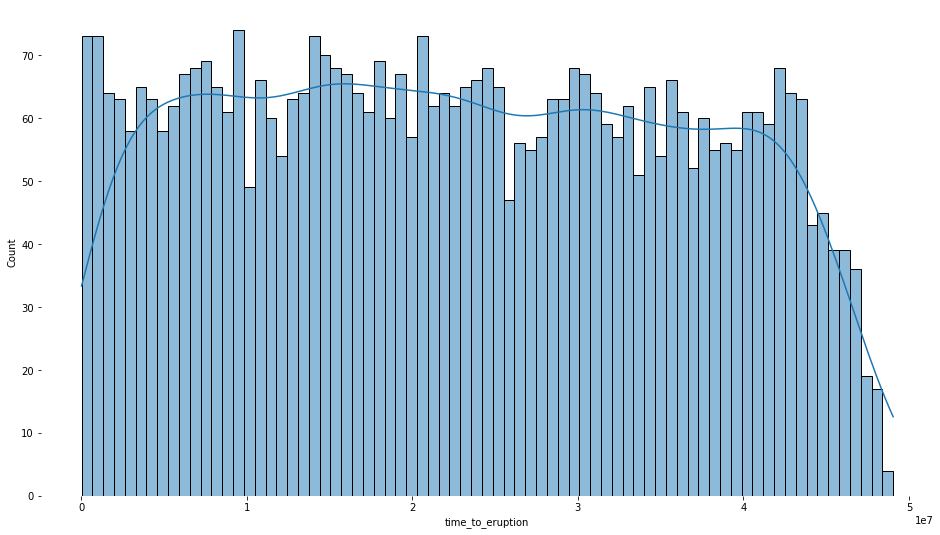

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
sns.histplot(data=target_csv, x="time_to_eruption", bins=75, kde=True, ax=ax)
[ax.spines[i].set_visible(False) for i in ax.spines.keys() if i != "buttom"]

Podemos ver de las gráficas anteriores que la distribución de los tiempos de erupción es simétrica pero no tiene forma de campana. Incluso se podría pensar que pareciera uniforme excepto por el límite superior que desciende.


#### Exploración del sensado

In [15]:
train_filenames = os.listdir(train_dir)
len(train_filenames)

4431

In [16]:
# Todo esto que sigue también ya se hizo
def get_stats_per_df(df):
    aggs = df.agg(["count", np.nanmean, np.nanstd, np.nanmin, np.nanmax])
    aggs = aggs.stack()
    aggs.index = aggs.index.map(lambda t:f"{t[1]}_{t[0]}")
    return aggs

In [ ]:
# Todo esto que sigue también ya se hizo, toma su tiempo
%%time
stats_per_file = []
for i,filename in enumerate(train_filenames,1):
    df = pd.read_csv(os.path.join(train_dir_path, filename), dtype="Int16")
    temporal_stats = get_stats_per_df(df)
    stats_per_file.append(temporal_stats)
    if i%50 == 0:
        print(i)

Vemos las estadísticas por archivo `.csv`

In [17]:
df_stats_per_file = pd.read_csv("../csvs/stats_per_file2.csv")
df_stats_per_file.head()

,segment_id,sensor_1_count,sensor_2_count,sensor_3_count,sensor_4_count,sensor_5_count,sensor_6_count,sensor_7_count,sensor_8_count,sensor_9_count,...,sensor_9_nanmax,sensor_10_nanmax,sensor_8_nanmean,sensor_8_nanstd,sensor_8_nanmin,sensor_8_nanmax,sensor_2_nanmean,sensor_2_nanstd,sensor_2_nanmin,sensor_2_nanmax
0,1136037770,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,3884.0,4912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969647810,60001.0,0.0,60001.0,60001.0,2072.0,60001.0,0.0,60001.0,55407.0,...,1373.0,4026.0,2.562674,759.108629,-4284.0,6339.0,NaN,NaN,NaN,NaN
2,1895879680,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,2182.0,4374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2068207140,60001.0,0.0,60001.0,60001.0,60001.0,60001.0,60001.0,0.0,60001.0,...,2605.0,3692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192955606,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,60001.0,...,1246.0,2288.0,0.743654,157.809455,-731.0,740.0,-1.041783,394.16549,-5766.0,5967.0


In [ ]:
def get_stats_vec(data):
    data_notnans = data[~np.isnan(data)]
    stats = [len, np.sum, lambda x:np.sum(x**2),
             lambda x:np.min(x) if len(x) else np.inf,
             lambda x:np.max(x) if len(x) else -np.inf]
    vec = [stat(data_notnans) for stat in stats]
    vec = np.array(vec)
    return vec

In [ ]:
def get_stats_vecs(df):
    vecs = [get_stats_vec(df[column]) for column in df.columns]
    matrix = np.vstack(vecs)
    return matrix

In [ ]:
# Ya se hizo, toma tiempo. 
%%time
stats = np.zeros(shape=(10,5))
stats[:,3] = np.inf
stats[:,4] = -np.inf
for filenames in train_filenames:
    df = pd.read_csv( os.path.join(train_dir_path, filename) )
    current_stats = get_stats_vecs(df)
    stats[:,:3] += current_stats[:,:3]
    stats[:,3] = np.minimum(stats[:,3], current_stats[:,3])
    stats[:,4] = np.maximum(stats[:,4], current_stats[:,4])

In [ ]:
def get_stats_df(matrix):
    sensors = [f"sensor_{i+1}" for i in range(10)]
    stats_names = ["count", "mean", "std", "min", "max"]
    
    nrows, ncols = matrix.shape
    
    stats_vecs = []
    for row in range(nrows): # for every sensor
        count = matrix[row,0]
        total_sum = matrix[row,1]
        mean = total_sum/count
        total_squared_sum = matrix[row,2]
        std = np.sqrt( (total_squared_sum - count*mean**2)/(count-1) )
        minimum = matrix[row,3]
        maximum = matrix[row,4]
        stats = [count, mean, std, minimum, maximum]
        stats_vecs.append(np.array(stats))
        
    new_matrix = np.vstack(stats_vecs)
    
    stats_df = pd.DataFrame(new_matrix, columns=stats_names, index=sensors)
    
    return stats_df

In [ ]:
# Ya se hizo y se tienen los datos guardados
whole_stats = get_stats_df(stats)
whole_stats

Ahora vienen los datos generales para cada sensor, se toman en cuenta TODOS los archivos `.csv`

In [19]:
whole_stats = pd.read_csv("../csvs/whole_stats.csv")
whole_stats

,count,mean,std,min,max
0,265864431.0,0.025250,203.303099,-1171.0,1278.0
1,265864431.0,-0.431776,418.222197,-4759.0,4118.0
2,265864431.0,0.233829,178.179004,-1288.0,1212.0
3,265864431.0,0.281562,200.602547,-1280.0,1532.0
4,265864431.0,-0.000650,161.583577,-1225.0,1370.0
5,265864431.0,0.044916,299.005016,-3226.0,2575.0
6,265864431.0,4.590190,204.956910,-986.0,983.0
7,265864431.0,-2.975500,247.542130,-934.0,1060.0
8,265864431.0,2.170547,196.562165,-1210.0,1316.0
9,265864431.0,-120.953801,937.478541,-3743.0,3229.0


## Análisis Visual de los Datos

In [ ]:
path_archivos = "/home/oscar/Escritorio/predict-volcanic-eruptions-ingv-oe/"
train_dir = path.join(path_archivos,"train")
train_filenames = listdir(train_dir)
muestra = pd.read_csv(path.join(train_dir, train_filenames[2]), dtype = "Int16")
muestra.head()

In [15]:
def graficar_amp_ply(df):
    validos = ~df.isna().all()
    validos = list(validos[validos].index)
    fig = make_subplots(rows = len(validos), cols=1, y_title = "Amplitudes", x_title = "Tiempo [cs]")
    for idx, sensor in enumerate(validos):
        datos = df.loc[:, sensor]
        fig.append_trace(go.Scatter(x = list(range(df.shape[0])), y = datos, 
                                    mode = "lines", name = f"{sensor}"), 
                                     row = idx+1, col = 1)

    fig.update_layout(height = 1000, width = 900, title_text = "Diagramas de amplitudes", title_font_size = 30)
    fig.show()

In [ ]:
graficar_amp_ply(muestra)

In [ ]:
muestra.head()

In [ ]:
train_path = path.join(path_archivos, "train.csv")
datos_train = pd.read_csv(train_path)
datos_train

In [ ]:
datos_train[datos_train.time_to_eruption.duplicated()]

In [ ]:
datos_train[datos_train.time_to_eruption == datos_train.time_to_eruption[1777]]

In [ ]:
igual1 = pd.read_csv(path.join(train_dir, "549832738.csv"))
graficar_amp_ply(igual1)

In [ ]:
igual2 = pd.read_csv(path.join(train_dir, "1049892705.csv"))
graficar_amp_ply(igual2)

In [ ]:
datos_ordenados = datos_train.iloc[datos_train.time_to_eruption.sort_values().index]
datos_ordenados.index = range(len(datos_ordenados))
datos_ordenados

In [ ]:
def graf(n):
    graficar_amp_ply(pd.read_csv(path.join(path_archivos, f"train/{datos_ordenados.iloc[n,0]}.csv")))

In [ ]:
graf(0)

In [ ]:
graf(-1)

## Análisis de señales

¿Cuáles serán las características que utilizaremos?

Librosa
- [x] zero_crossings
---
Peak finding
- [x] find_peaks (max)
- [ ] find_peaks_cwt
- [x] peak_prominences
---
Spectral analysis
- [x] periodogram
- [ ] csd
- [ ] coherence
- [ ] stft

In [45]:
def get_chars(df, nombre):
    cars = [int(nombre[:-4])]
    # zeros_crossings
    cars.extend(librosa.zero_crossings(df.values, axis = 0).sum(axis = 0))
    # find_peaks
    cars.extend(df.apply(find_peaks, axis = 0).iloc[0,:].apply(len).values)
    # peak_widths_max
    λ0 = lambda x: np.max(peak_widths(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    cars.extend(df.apply(λ0).values)
    # peak_widths_mean
    λ01 = lambda x: np.mean(peak_widths(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    cars.extend(df.apply(λ01).values)
    # peak_prominences_max
    λ1 = lambda x: np.max(peak_prominences(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    cars.extend(df.apply(λ1).values)
    # peak_prominences_mean
    λ11 = lambda x: np.mean(peak_prominences(x, find_peaks(x)[0])[0]) if len(find_peaks(x)[0]) != 0 else 0
    cars.extend(df.apply(λ11).values)
    # periodogram_max
    λ2 = lambda x: np.max(periodogram(x, 100)[1]) if ~x.isna().all() else 0
    cars.extend(np.sqrt(df.apply(λ2).values)) # Es un estimado del RMS
    # periodogram_mean
    λ3 = lambda x: np.mean(periodogram(x, 100)[1]) if ~x.isna().all() else 0
    cars.extend(df.apply(λ3).values)
    return cars

## Implementando LGBM

In [2]:
# Búsqueda de hiperparámetros
def random_search(X_train, y_train, X_test, y_test, its = 50):
    #Set the minimum error arbitrarily large
    minimo = float("inf") 
    pp = {}
    count = 0 #Used for keeping track of the iteration number
    maes = []
    pars = []
    #How many runs to perform using randomly selected hyperparameters
    iterations = its
    for i in range(iterations):
        print('iteration number', count)
        count += 1 #increment count
        params = {} #initialize parameters
        try:
            d_train = lgb.Dataset(X_train, label = y_train) #Load in data
            params['learning_rate'] = np.random.uniform(0, 1)
            params['boosting_type'] = np.random.choice(['gbdt', 'dart', 'goss'])
            params['objective'] = 'regression'
            params['metric'] = 'mae'
            params['sub_feature'] = np.random.uniform(0, 1)
            params['num_leaves'] = np.random.randint(20, 300)
            params['min_data'] = np.random.randint(10, 100)
            params['max_depth'] = np.random.randint(5, 200)
            iterations = np.random.randint(10, 10000)
            clf = lgb.train(params, d_train, iterations)
            y_pred = clf.predict(X_test) #Create predictions on test set
            mae = mean_absolute_error(y_pred,y_test)    
            print('MAE:', mae)
            print(params, iterations) #Train using selected parameters
            maes.append(mae)
            pars.append(params)
            if mae < minimo:
                minimo = mae
                pp = params
        except: #in case something goes wrong
            print('failed with')
            print(params)
    return maes, pars, minimo, pp

### Mejores hiperparámetros encontrados: 

MAE: 2547251.821188033

- 'learning_rate': 0.14124527912898743
- 'boosting_type': 'dart'
- 'objective': 'regression'
- 'metric': 'mae'
- 'sub_feature': 0.5486980094996131
- 'num_leaves': 43
- 'min_data': 23
- 'max_depth': 68

In [47]:
%%time
# Creando los vectores de características
path_test = "/home/oscar/Escritorio/estandarizados/test"
todos = []
i = 0
for archivo in listdir(path_test):
    camino = path.join(path_test, archivo)
    df = pd.read_csv(camino)
    try:
        chars = get_chars(df, archivo)
        todos.append(chars)
    except:
        print(archivo)
    #print(i)
    i += 1
    
caracteristicas = "zcr peaks peak_wmax peak_wmean peak_promax peak_promean period_max period_mean". split()
cols = ["segment_id"] + [f"sensor_{idx}_{car}" for car in caracteristicas for idx in range(1,11)]
df_todos = pd.DataFrame(todos, columns = cols)
df_todos.to_csv("../csvs/stats_per_file_signal_test.csv", index = False)

CPU times: user 13min 38s, sys: 3.76 s, total: 13min 42s
Wall time: 13min 50s


In [7]:
# Entrenamiento
datos = pd.read_csv("../csvs/stats_per_file_signal_train_normal.csv")
train = pd.read_csv("/home/oscar/Escritorio/predict-volcanic-eruptions-ingv-oe/train.csv")
datos_time = datos.join(train.set_index("segment_id"), on = "segment_id")

X = datos_time.iloc[:,1:-1].values
y = datos_time.iloc[:,-1].values
# Creemos que es importante separar los datos y no contemplar todo el conjunto porque estamos 
# sobreajustando el modelo (no funcionó)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

params = {}
d_train = lgb.Dataset(X, label = y)
params['learning_rate'] = 0.020881591516791632
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] =  0.570967691065
params['num_leaves'] = 244
params['min_data'] = 12
params['max_depth'] = 93
params['verbose'] = -1
iterations = 798
clf = lgb.train(params, d_train, iterations)

In [8]:
# Prueba
X_test = pd.read_csv("../csvs/stats_per_file_signal_test_normal.csv").values[:, 1:]
y_pred = clf.predict(X_test) #Create predictions on test set

ss = pd.read_csv("../csvs/stats_per_file_signal_test_normal.csv").iloc[:, :2]
ss.iloc[:, 1] = y_pred
ss.rename(columns = {"sensor_1_zcr":"time_to_eruption"}, inplace = True)
ss.to_csv("../csvs/submission6.csv", index = False)

## Checando nuestro modelo con validación cruzada